## Preparação do ambiente

In [64]:
import pandas as pd
import numpy as np

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [67]:
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix

In [68]:
# Código usado nessa plotagem, com modificações: https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels

def plot_confusion_matrixes(matrixes, n=1):
    plt.rcParams["figure.figsize"] = (8,3.8)
    plt.rcParams["figure.dpi"] = (70)
    
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    if n > 1:
        for i in range(len(matrixes)):
            ax_index = int((i % 2) != 0)
            
            if ax_index == 0:
                fig, ax = plt.subplots(1,2)
                sns.heatmap(matrixes[i], annot=True, fmt='g', ax=ax[ax_index], cbar=False)

                ax[ax_index].set_xlabel('Predicted labels')
                ax[ax_index].set_ylabel('True labels')
                ax[ax_index].set_title('Confusion Matrix: Fold ' + str(i))
                ax[ax_index].xaxis.set_ticklabels(['Carrier', 'Not carrier'])
                ax[ax_index].yaxis.set_ticklabels(['Carrier', 'Not carrier'])

            else:
                sns.heatmap(matrixes[i], annot=True, fmt='g', ax=ax[ax_index], cbar=False)

                ax[ax_index].set_xlabel('Predicted labels')
                ax[ax_index].set_ylabel('True labels')
                ax[ax_index].set_title('Confusion Matrix: Fold ' + str(i))
                ax[ax_index].xaxis.set_ticklabels(['Carrier', 'Not carrier'])
                ax[ax_index].yaxis.set_ticklabels(['Carrier', 'Not carrier'])
        
    plt.show()

## Exploração inicial dos dados

### Carregamento dos dados

In [69]:
# Dataset utilizado: https://github.com/zahangirbd/medical_data_for_classification/tree/master/data/Hepatitis

train = pd.read_csv("./data/hepatitis.data.train.csv")
test = pd.read_csv("./data/hepatitis.data.test.csv")

In [70]:
# Dataset original vem já com divisão de treino e teste, mas que é desnecessária aqui

data = pd.concat([train, test], ignore_index=True)

### Tratamento dos dados

In [71]:
numerical = ["AGE", "BILIRUBIN", "ALK_PHOSPHATE", "SGOT", "ALBUMIN",
            "PROTIME"]
categorical = ["SEX", "STEROID", "ANTIVIRALS", "FATIGUE", "MALAISE",
              "ANOREXIA", "LIVER_BIG", "LIVER_FIRM", "SPLEEN_PALPABLE",
              "SPIDERS", "ASCITES", "VARICES", "HISTOLOGY"]
classifier = "CLASS"

In [72]:
# Visão geral de dados faltantes na base

missing_data_overview = pd.DataFrame((data[numerical + categorical] == '?').sum()).rename(columns={0: 'missing_data'})
missing_data_overview['missing_prop'] = round(100*(missing_data_overview['missing_data']/len(data)), 2)
missing_data_overview = missing_data_overview.sort_values('missing_prop', ascending=False)

missing_data_overview['type'] = missing_data_overview.index.isin(numerical)
missing_data_overview['type'] = missing_data_overview['type'].replace(True, 'numerical').replace(False, 'categorical')

In [73]:
missing_data_overview

,missing_data,missing_prop,type
PROTIME,67,43.23,numerical
ALK_PHOSPHATE,29,18.71,numerical
ALBUMIN,16,10.32,numerical
LIVER_FIRM,11,7.10,categorical
LIVER_BIG,10,6.45,categorical
BILIRUBIN,6,3.87,numerical
SPIDERS,5,3.23,categorical
VARICES,5,3.23,categorical
ASCITES,5,3.23,categorical
SPLEEN_PALPABLE,5,3.23,categorical


In [74]:
data_mod = data.copy()

In [75]:
# Porcentagem de dados que serão perdidos com a escolha de remover linhas com dados categóricos ausentes

(data_mod[categorical] == '?').any(axis="columns").sum()/len(data_mod)

0.08387096774193549

In [76]:
# Remoção das linhas com dados categóricos faltantes

for cat in categorical:
    data_mod = data_mod.drop(index=data_mod[data_mod[cat] == '?'].index)
    data_mod[cat] = data_mod[cat].astype(int)
    data_mod[cat] = pd.get_dummies(data_mod[cat], drop_first=True).iloc[:, 0].values

In [77]:
# Para os dados numéricos, valores faltantes foram zerados

data_mod[numerical] = data_mod[numerical].replace('?', '0').astype(float)

In [78]:
# Os dados categóricos são binários, podendo ser transformados em dummy data
# Com isso, é possível passar nos modelos do scikit-learn, que não aceitam valores categóricos

for cat in categorical:
    data_mod = data_mod.drop(index=data_mod[data_mod[cat] == '?'].index)
    data_mod[cat] = data_mod[cat].astype(int)
    data_mod[cat] = pd.get_dummies(data_mod[cat], drop_first=True).iloc[:, 0].values

### Visualização dos dados

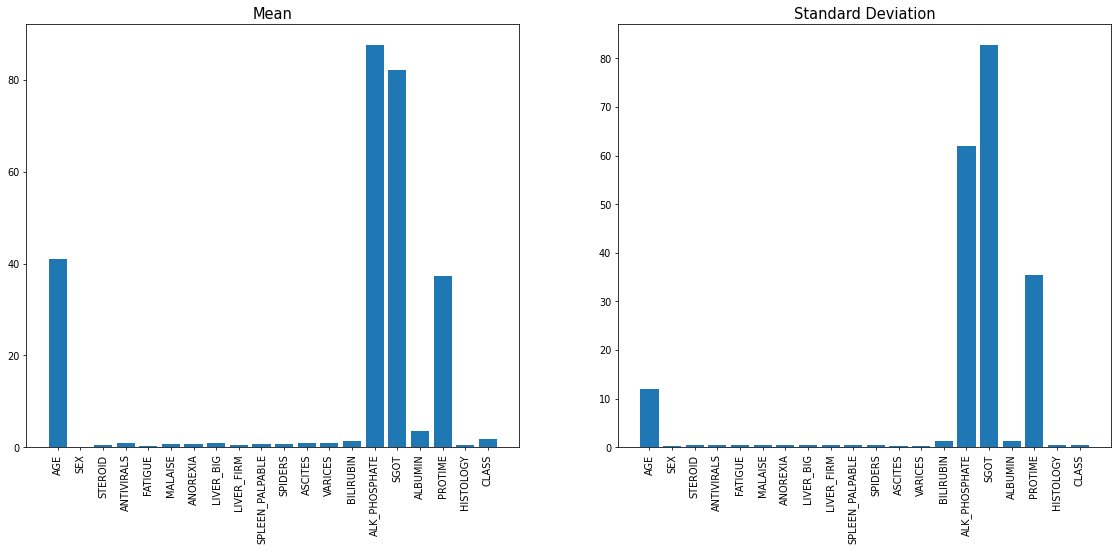

In [79]:
# Visualização de média e desvio padrão dos dados

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

ax1.set_title('Mean', size=15)
ax1.bar(data_mod.mean().keys(), data_mod.mean().values)
ax1.xaxis.set_tick_params(rotation=90)

ax2.set_title('Standard Deviation', size=15)
ax2.bar(data_mod.std().keys(), data_mod.std().values)
ax2.xaxis.set_tick_params(rotation=90)

plt.show()

## Treinamento de modelos

In [80]:
feature_keys = numerical + categorical

In [81]:
X = data_mod[feature_keys].to_numpy()
y = data_mod[classifier].to_numpy()

### Decision tree (CART)

In [82]:
model_tree = tree.DecisionTreeClassifier()
cv_tree = StratifiedKFold(n_splits=10)

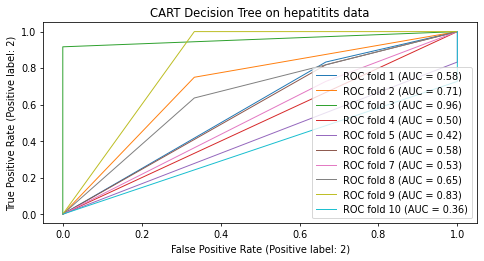

In [83]:
cms_tree = []
f1s_tree = []

# Código usado para plotar a curva ROC de validação cruzada, com modificações: https://stackoverflow.com/questions/66033370/plot-roc-curve-from-cross-validation

plt.rcParams["figure.figsize"] = (8,3.8)
plt.rcParams["figure.dpi"] = (70)
fig, ax = plt.subplots()

for i, (train, test) in enumerate(cv_tree.split(X, y)):
    model_tree.fit(X[train], y[train])
    viz = plot_roc_curve(model_tree, X[test], y[test],
                         name='ROC fold {}'.format(i+1),
                         alpha=1, lw=1, ax=ax)

    y_pred = model_tree.predict(X[test])
    cms_tree.append(confusion_matrix(y[test], y_pred))
    f1s_tree.append(f1_score(y[test], y_pred))

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="CART Decision Tree on hepatitits data")
ax.legend(loc="lower right")
plt.show()

<Figure size 560x266 with 0 Axes>

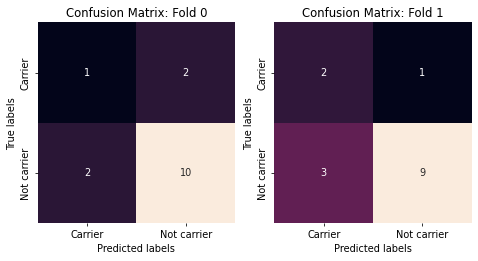

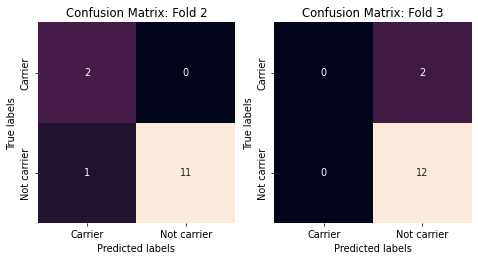

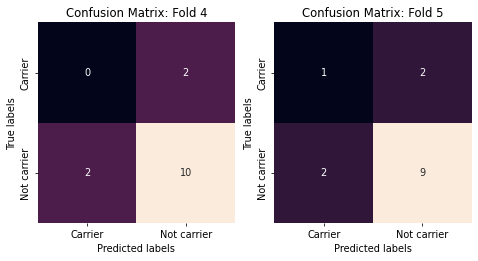

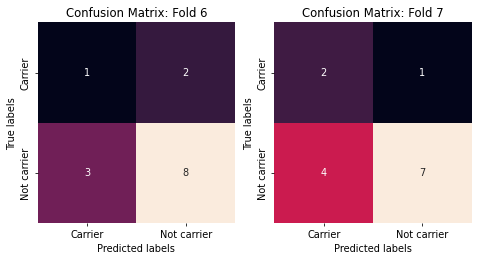

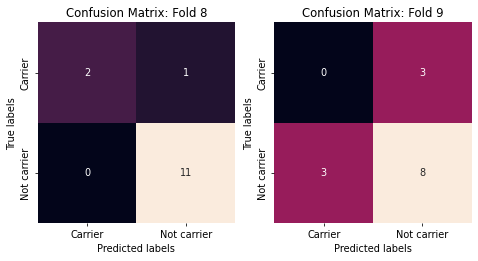

In [84]:
plot_confusion_matrixes(cms_tree, len(cms_tree))

In [85]:
print("O f1 médio da validação cruzada do modelo de Decision Tree é de: {0:.3f}".format(np.mean(f1s_tree)))

O f1 médio da validação cruzada do modelo de Decision Tree é de: 0.350


### Random Forest (m=19)

In [86]:
model_forest_19 = RandomForestClassifier(n_estimators=100, max_features=19)
cv_forest_19 = StratifiedKFold(n_splits=10)

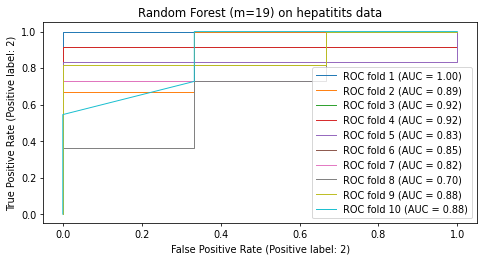

In [87]:
cms_forest_19 = []
f1s_forest_19 = []

plt.rcParams["figure.figsize"] = (8,3.8)
plt.rcParams["figure.dpi"] = (70)
fig, ax = plt.subplots()

for i, (train, test) in enumerate(cv_forest_19.split(X, y)):
    model_forest_19.fit(X[train], y[train])
    viz = plot_roc_curve(model_forest_19, X[test], y[test],
                         name='ROC fold {}'.format(i+1),
                         alpha=1, lw=1, ax=ax)

    y_pred = model_forest_19.predict(X[test])
    cms_forest_19.append(confusion_matrix(y[test], y_pred))
    f1s_forest_19.append(f1_score(y[test], y_pred))

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Random Forest (m=19) on hepatitits data")
ax.legend(loc="lower right")
plt.show()

<Figure size 560x266 with 0 Axes>

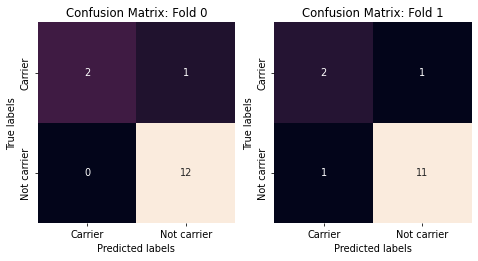

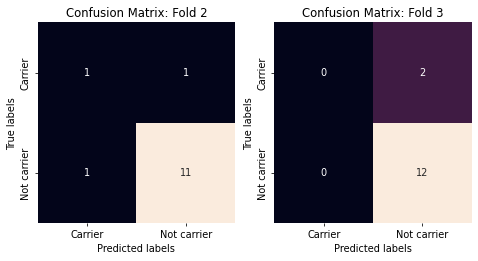

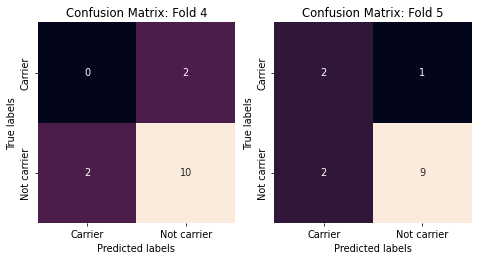

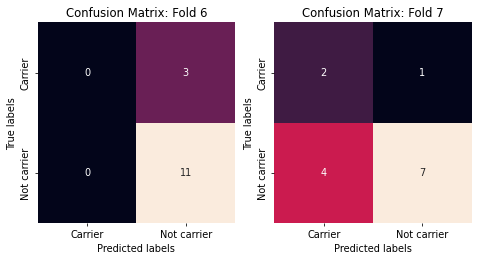

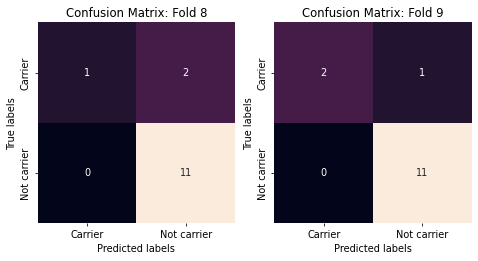

In [88]:
plot_confusion_matrixes(cms_forest_19, len(cms_forest_19))

In [89]:
print("O f1 médio da validação cruzada do modelo Random Forest (m=19) é de: {0:.3f}".format(np.mean(f1s_forest_19)))

O f1 médio da validação cruzada do modelo Random Forest (m=19) é de: 0.428


In [90]:
features_overview = dict(zip(feature_keys, model_forest_19.feature_importances_))
{k: v for k, v in sorted(features_overview.items(), key=lambda item: item[1], reverse=True)}

{'BILIRUBIN': 0.21558407073013622,
 'ASCITES': 0.13437093895304084,
 'ALBUMIN': 0.1286123539638832,
 'SGOT': 0.09756150812173478,
 'ALK_PHOSPHATE': 0.09050292293308265,
 'AGE': 0.06948993467567469,
 'PROTIME': 0.06074192186084553,
 'SPIDERS': 0.051677039775679834,
 'VARICES': 0.041415187088488306,
 'SPLEEN_PALPABLE': 0.020381779322993253,
 'LIVER_FIRM': 0.01865178453795199,
 'MALAISE': 0.017423125428459845,
 'LIVER_BIG': 0.011823674357746077,
 'FATIGUE': 0.009491656222777655,
 'HISTOLOGY': 0.009234422094984507,
 'STEROID': 0.0072688665538086965,
 'ANOREXIA': 0.006857323722954952,
 'SEX': 0.005778193315095649,
 'ANTIVIRALS': 0.003133296340661455}

### Random Forest (m=4)

In [91]:
model_forest_4 = RandomForestClassifier(n_estimators=100, max_features=4)
cv_forest_4 = StratifiedKFold(n_splits=10)

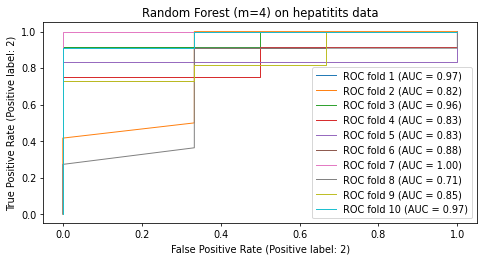

In [92]:
cms_forest_4 = []
f1s_forest_4 = []

plt.rcParams["figure.figsize"] = (8,3.8)
plt.rcParams["figure.dpi"] = (70)
fig, ax = plt.subplots()

for i, (train, test) in enumerate(cv_forest_4.split(X, y)):
    model_forest_4.fit(X[train], y[train])
    viz = plot_roc_curve(model_forest_4, X[test], y[test],
                         name='ROC fold {}'.format(i+1),
                         alpha=1, lw=1, ax=ax)

    y_pred = model_forest_4.predict(X[test])
    cms_forest_4.append(confusion_matrix(y[test], y_pred))
    f1s_forest_4.append(f1_score(y[test], y_pred))

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Random Forest (m=4) on hepatitits data")
ax.legend(loc="lower right")
plt.show()

<Figure size 560x266 with 0 Axes>

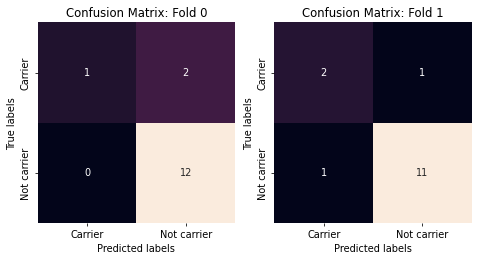

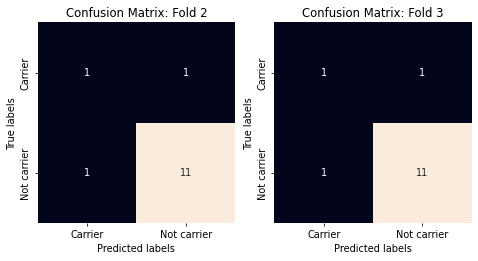

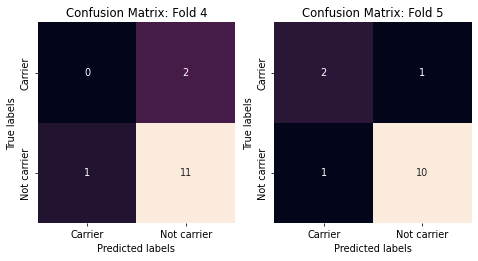

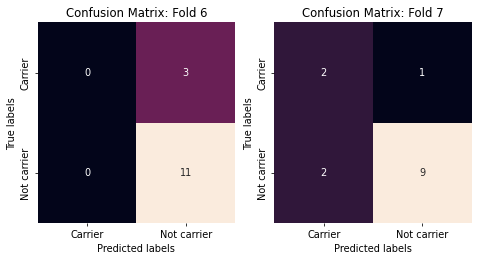

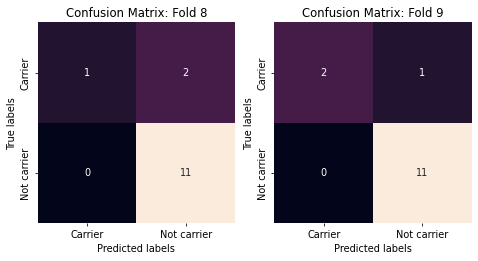

In [93]:
plot_confusion_matrixes(cms_forest_4, len(cms_forest_4))

In [94]:
print("O f1 médio da validação cruzada do modelo Random Forest (m=4) é de: {0:.3f}".format(np.mean(f1s_forest_4)))

O f1 médio da validação cruzada do modelo Random Forest (m=4) é de: 0.470


In [95]:
features_overview = dict(zip(feature_keys, model_forest_4.feature_importances_))
{k: v for k, v in sorted(features_overview.items(), key=lambda item: item[1], reverse=True)}

{'BILIRUBIN': 0.15102265445594013,
 'ALBUMIN': 0.14737321877640316,
 'SGOT': 0.09256708515333464,
 'ALK_PHOSPHATE': 0.08661644558154435,
 'ASCITES': 0.07617866557781677,
 'PROTIME': 0.07535573125698226,
 'AGE': 0.07368401463843663,
 'SPIDERS': 0.06822123265848996,
 'VARICES': 0.04114059658693643,
 'SPLEEN_PALPABLE': 0.035949953541704306,
 'MALAISE': 0.026804244107332065,
 'LIVER_BIG': 0.023459224446313584,
 'HISTOLOGY': 0.0218273243561564,
 'LIVER_FIRM': 0.021506208656520465,
 'FATIGUE': 0.016214988488423784,
 'ANOREXIA': 0.014204580951393802,
 'STEROID': 0.012240283728438401,
 'SEX': 0.009563984912070271,
 'ANTIVIRALS': 0.006069562125762604}

## Comentários finais

O melhor resultado obtido foi o modelo de Floresta Randômica com raiz quadrada de variáveis preditoras. Nesse caso, temos que as 2 principais features foram as informações de BILIRUBIN e ALBUMIN, ambas variáveis numéricas.

In [96]:
f1s_forest_4_features = {k: v for k, v in sorted(features_overview.items(), key=lambda item: item[1], reverse=True)}

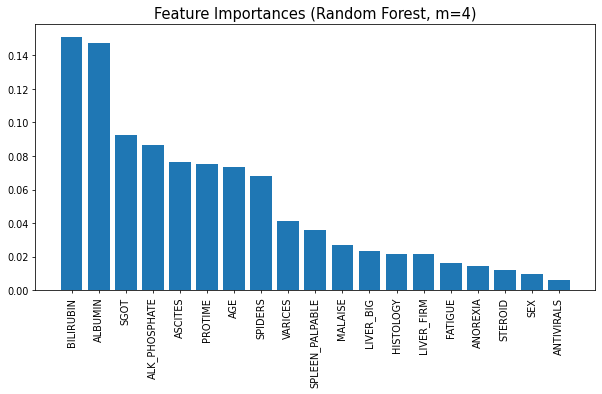

In [97]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.set_title('Feature Importances (Random Forest, m=4)', size=15)
ax.bar(f1s_forest_4_features.keys(), f1s_forest_4_features.values())
ax.xaxis.set_tick_params(rotation=90)

plt.show()

Como visto nas aulas teóricas, esse é um resultado esperado, já que o uso de um número limitado de variáveis em cada árvore da floresta permite identificar combinações de features mais bem-sucedidas na predição, independentes entre si.

Também é possível observar que a árvore de decisão foi o modelo com menor acurácia, o que também já era esperado, como visto nas aulas teóricas. Isso acontece porque a floresta randômica explora diferentes árvores de decisão, com ensemble learning.